# Project: Final Report

1. Title
   
2. Introduction
- background on the topic, so someone unfamiliar can understand the rest of the project
- state the question we try to answer through the project
- identify and describe the dataset that was used to answer
  
3. Methods and Results
- describe methods used to perfoem your analysis
- loads data
- wrangles and cleans the data
- summary of the data set that is relevant for exploratory data analysis
- perform data analysis
- visualization

4. Discussion
- summarize what you found
- discuss whether this is what you expected to find
- discuss what impact could such findings have
- discuss what future question could this lead to

5. References (if necessary)

- response variable: played_hours
- predict variable: age and gender

## Introduction

**Background:**
Can age and gender predict played hours in 
**Question:**

## Methods and Results

**Describe methods used to perfoem your analysis**

We will be using K-Nearest Neighbors (KNN) regression model, using cross-
validation to find the optimal number of neighbors.

We will start by Loading the data:

In [11]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(RColorBrewer)

In [12]:
url <- "https://raw.githubusercontent.com/hy-008/dsci_project_1/refs/heads/main/data/players.csv"
player <- read_csv(url)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [13]:
player

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


**Wrangles and Cleaning the data**

We will select the columns played_hours, Age, and gender from the data, and ensure
that any NA values are filtered out. Additionally, we will be binarizing our data for kNN regression, representing female as 1 and male as 2

Upon reviewing, we found that out of 196 entries, 33 entries are labeled as neither
"Male" nor "Female". While it is important to acknowledge and respect all gender
identities, for the purpose of our analysis, we will focus on the "Male" and "Female"
categories as it makes up a much bigger sample size. Including all other gender
categories could lead to reduced model's performance during kNN regression.

In [14]:
player <- player |>
select(played_hours, Age, gender) |>
filter(gender == c("Male", "Female")) |>
mutate(gender = as.numeric(factor(gender)))

player

played_hours,Age,gender
<dbl>,<dbl>,<dbl>
30.3,9,2
0.0,17,2
0.7,21,1
⋮,⋮,⋮
0.0,17,1
0.3,22,2
2.3,17,2


We then set a seed and split the data to ensure a reproducible analysis. This step
guarantees that the training and testing sets are representative of the original data, which can be used to build our kNN regression model effectively.

In [15]:
set.seed(1)

player_split <- initial_split(player, prop = 0.7, strata = played_hours)
player_training <- training(player_split)
player_testing <- testing(player_split)

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 3 breaks instead.”


**Summarize the dataset** We used the summary() function to provide comprehensive
overview of the data, including key statistics such as mean, median, minimum, and maximum values for each column.

In [16]:
summary_player <- summary(player)
cat("\nSummary Statistics:\n")
summary_player


Summary Statistics:


  played_hours          Age            gender     
 Min.   :  0.000   Min.   : 8.00   Min.   :1.000  
 1st Qu.:  0.000   1st Qu.:17.00   1st Qu.:2.000  
 Median :  0.100   Median :18.50   Median :2.000  
 Mean   :  5.400   Mean   :19.49   Mean   :1.795  
 3rd Qu.:  0.875   3rd Qu.:22.00   3rd Qu.:2.000  
 Max.   :223.100   Max.   :46.00   Max.   :2.000  

**Visualization of the Dataset**

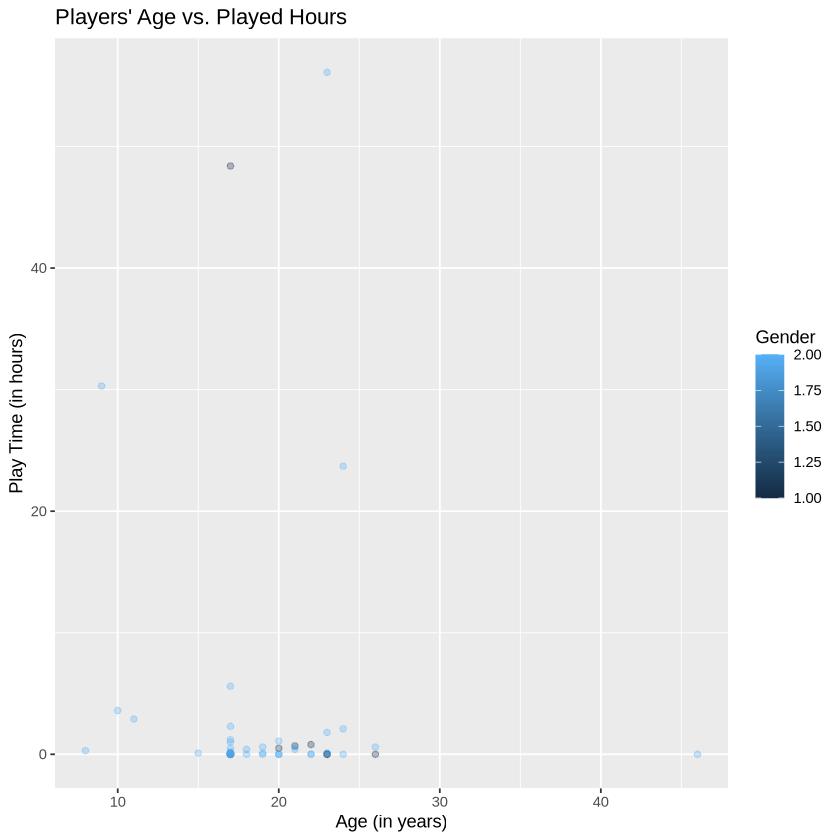

In [17]:
hours_chart <- player_training |>
                ggplot(aes(x = Age, y = played_hours, color = gender)) +
                geom_point(alpha = 0.3) + #there is overplotting
                labs(x = "Age (in years)", 
                     y = "Play Time (in hours)", color = "Gender") +
                ggtitle("Players' Age vs. Played Hours") 
hours_chart

**Performing the Data Analysis**

The process includes creating a recipe, where all predictors' values are normalized
(scale and center), which is important as it ensures that all features contribute
equally to the model. Then, we plan to use a 5-fold cross-validation for our data,
which will be used to tune the model. Finally, we want to find the best number for k
value. This is done by slicing the row with the lowest value of RMSE.

In [18]:
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

player_recipe <- recipe(played_hours ~ Age + gender, data = player_training) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

player_vfold <- vfold_cv(player_training, v = 5, strata = played_hours)

player_wf <- workflow() |>
                add_recipe(player_recipe) |>
                add_model(player_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 25, by = 1))

player_results <- player_wf |>
                    tune_grid(resample = player_vfold, grid = gridvals) |>
                    collect_metrics()

player_min <- player_results |>
                filter(.metric == "rmse") |>
                slice_min(order_by = mean, n = 1)

player_results
player_min

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 2 breaks instead.”


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,11.97470834,5,3.246868992,Preprocessor1_Model01
1,rsq,standard,0.01665388,5,0.004575902,Preprocessor1_Model01
2,rmse,standard,11.69904419,5,2.795907177,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
24,rsq,standard,0.04569143,5,0.02671007,Preprocessor1_Model24
25,rmse,standard,9.62567434,5,3.04354074,Preprocessor1_Model25
25,rsq,standard,0.15684071,5,0.09352489,Preprocessor1_Model25


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
24,rmse,standard,9.603852,5,3.028109,Preprocessor1_Model24


In [19]:
k_min <- player_min |>
        pull(neighbors)

player_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

player_best_fit <- workflow() |>
         add_recipe(player_recipe) |>
         add_model(player_best_spec) |>
         fit(data = player_training)

player_summary <- player_best_fit |>
          predict(player_testing) |>
          bind_cols(player_testing) |>
          metrics(truth = played_hours, estimate = .pred)

player_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,45.5051697
rsq,standard,0.0601851
mae,standard,11.4876736


**Visualization of the Analysis**

Despite removing any missing values, the minimum RMSE value is still high (45.5).
This is caused by the presence of outliers in played hours, as seen in the summary
table. To better understand the relationship, this is the visualization of the
relationship between age and gender with played_hours

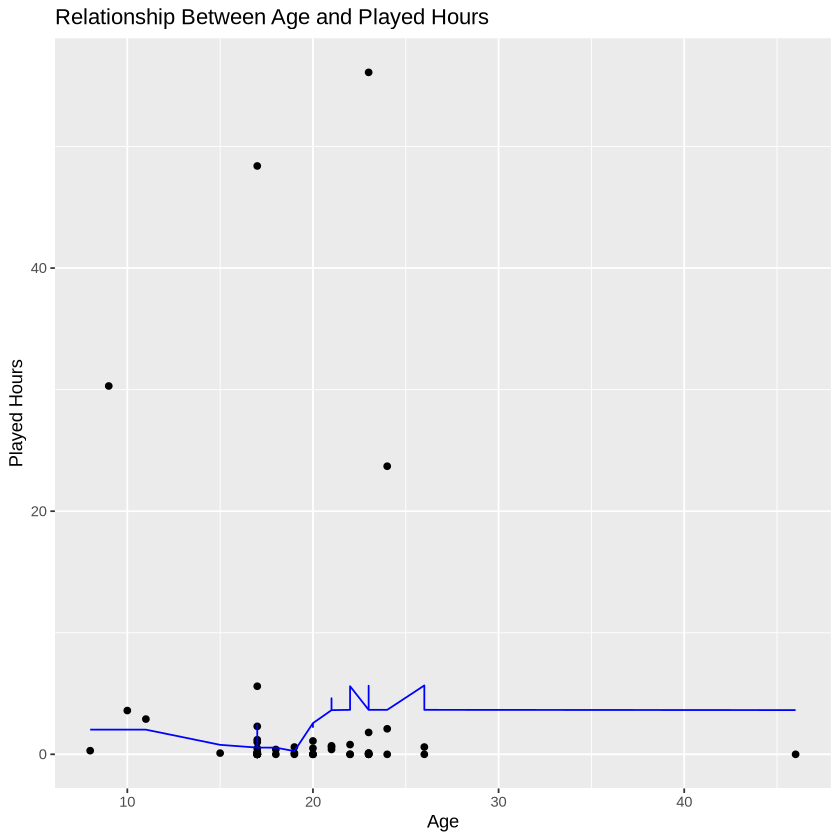

In [20]:
options(repr.plot.width = 7, repr.plot.height = 7)

player_preds <- player_best_fit |>
predict(new_data = player_training) |>
bind_cols(player_training)

player_plot <- ggplot(player_preds, aes(x = Age, y = played_hours)) +
geom_point() +
geom_line(aes(x = Age, y = .pred), color = "blue") +
labs(
    title = "Relationship Between Age and Played Hours",
    x = "Age",
    y = "Played Hours"
)

player_plot